# **Assignment 1 ROB313**

In [1]:
# Import revelant libraries

import numpy as np
import matplotlib.pyplot as plt
from time import time
from data.data_utils import load_dataset
from sklearn.neighbors import KDTree
from scipy.linalg import svd
np.random.seed(21)

**Question 1)**

- Implement k-NN algorithm for regression with two different distance metrics (l1 and l2)
- Use 5-fold cross validation to estimate k -> train on 4/5 of data and test on remaining
- Determine preferred distance metric and k value using RMSE loss

In [3]:
def knn_regression(x_train, y_train, x_test, k, l):
    # For regression, our prediction for x* is just the average output across the k nearest neighbours in the training dataset 
    y_est = np.zeros((len(x_test), 1))
    # Implement l1 and l2 distance metrics for comparison
    for i, test_pt_array in enumerate(x_test):
        # For each validation POINT, we will compute an estimate of its y value
        if l == 1:
            # Reshape for 1D -> 2D and calculate distance
            dist_l1 = np.sum(np.abs(x_train-test_pt_array.reshape((1,-1))), axis=1)
            # Sort distances for minimization and return as list of indices up to k
            ind_l1 = np.argpartition(dist_l1, kth=k)[:k]
            # Calculate averages based on each distance metric (finding corresponding y values based on x value indices)
            y_est[i,0] = np.mean(y_train[ind_l1])

        elif l == 2:
            # Reshape for 1D -> 2D and calculate distance
            dist_l2 = np.sqrt(np.sum(np.square(x_train-test_pt_array.reshape((1,-1))), axis=1))
            # Sort distances for minimization and return as list of indices up to k
            ind_l2 = np.argpartition(dist_l2, kth=k)[:k]
            # Calculate averages based on each distance metric
            y_est[i,0] = np.mean(y_train[ind_l2])

    return y_est

In [4]:
def five_fold_crossval(x_train, x_valid, x_test, y_train, y_valid, y_test, dataset):
    # Use 5-fold cross validation to determine the optimal value of k
    x_train = np.vstack([x_valid, x_train])
    y_train = np.vstack([y_valid, y_train])
    # Figure out size of array needed based on training data size
    n = len(x_train)
    max_k = int(np.sqrt(n))
    size = int(5*np.ceil(n/5))
    # Initially fill folds array with -1s. Then replace first n elements with random indices on the range of n and reshape for 5 splits  
    five_folds = -np.ones(size, dtype=int)
    five_folds[:n] = np.arange(n, dtype=int)
    five_folds = np.random.permutation(five_folds).reshape(5,-1)

    # Perform 5 fold cross validation for multiple different k values
    rmse = np.empty((max_k, 2))

    # Plot exact data of mauna_loa if being used
    if dataset == 'mauna_loa':
        plt.xlabel('Month')
        plt.ylabel('CO2 Measurement')
        plt.title('Mauna Loa KNN Performance for l2 Hyperparameter')
        plt.plot(x_train, y_train, 'k', label='Raw Data', alpha=0.3)

    for k in range(1,max_k+1):
        rmse_set = np.zeros((5, 2))
        # Define results array so that we can plot the kNN results over all x_train for l2 as we go (at particular k values)
        results = np.zeros(n).reshape(-1,1)
        results[:] = np.nan
        # Train on everything except ith fold, which will be used for testing
        for i in range(5):
            # Create array that is rid of the -1 placeholders for validation set
            validset_inds = five_folds[i, five_folds[i] >= 0]
            # Remove validation set so that we can use the remaining data as the training
            trainset_inds = np.delete(five_folds, i, axis=0).reshape(-1)
            trainset_inds = trainset_inds[trainset_inds >= 0]
            # Assign values for validation and training sets based on the index arrays we created
            x_valid_set = x_train[validset_inds]
            y_valid_set = y_train[validset_inds]
            x_train_set = x_train[trainset_inds]
            y_train_set = y_train[trainset_inds]
            # Run regression algorithm for both l1 and l2 distance metrics using specific k value
            y_est_l1 = knn_regression(x_train_set, y_train_set, x_valid_set, k, 1)
            y_est_l2 = knn_regression(x_train_set, y_train_set, x_valid_set, k, 2)
            # Results array will accumulate to store the kNN predictions for all x_train with a specific k value
            results[validset_inds] = y_est_l2
            # Calculate RMSE for both distance metrics and store them in their respective columns (validation procedure)
            rmse_set[i][0] = np.sqrt(np.mean(np.square(y_est_l1 - y_valid_set)))
            rmse_set[i][1] = np.sqrt(np.mean(np.square(y_est_l2 - y_valid_set)))

        # Add k=2, k=11, k=23 kNN results to plot
        if dataset == 'mauna_loa' and k in [2,11,23]:
            # Plot k regression results
            plt.plot(x_train, results, label='k = %d performance' % k)
            plt.legend(loc=0)
    
        # Find average RMSE error for both distance metrics for specific k value
        rmse[k-1][0] = np.mean(rmse_set[:, 0])
        rmse[k-1][1] = np.mean(rmse_set[:, 1])

    # Choose best k value and distance metric based on results
    min_ind = np.unravel_index(np.argmin(rmse, axis=None), rmse.shape)
    min_rmse = np.min(rmse)
    k_best = min_ind[0] + 1
    if min_ind[1] == 0:
        l_best = 'l1'
        l_best_val = 1
    else:
        l_best = 'l2'
        l_best_val = 2
    
    # Using solved optimal hyperparameters, rerun regression algorithm using test data and see how well it does
    y_test_est = knn_regression(x_train, y_train, x_test, k_best, l_best_val)
    test_rmse = np.sqrt(np.mean(np.square(y_test_est - y_test)))

    # For purposes of the assignment, plot cross validation prediction curves for mauna_loa data:
    if dataset == 'mauna_loa':
        # RMSE Curve
        plt.figure()
        plt.xlabel('k')
        plt.ylabel('RMSE Error')
        plt.title('Mauna Loa Cross Validation: k vs. RMSE for l2 Hyperparameter')
        k = np.arange(1, max_k+1)
        plt.plot(k, rmse[:, 1])

        # Prediction Curve Using Test Set - How well does k do on test data
        plt.figure()
        x_exact = np.vstack([x_train, x_test])
        y_exact = np.vstack([y_train, y_test])
        plt.xlabel('Month')
        plt.ylabel('CO2 Measurement')
        plt.title('Mauna Loa Data Propogation and Prediction for Test Set Using l2 Hyperparameter and k=%d' % k_best)
        plt.plot(x_exact, y_exact, 'r', label='Raw Data')
        plt.plot(x_test, y_test_est, label='k=%d Predicted Propogation on Test Set' % k_best)
        plt.legend(loc=0)

    return k_best, l_best, min_rmse, test_rmse

Now that we have our regression and cross validation algorithms, we can create a function to load and plot the available data sets based on user specifications:

2
l1
0.03427278127288702
0.44070489035463933


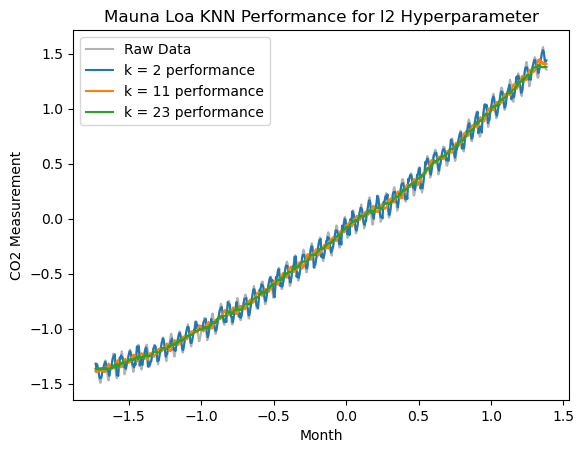

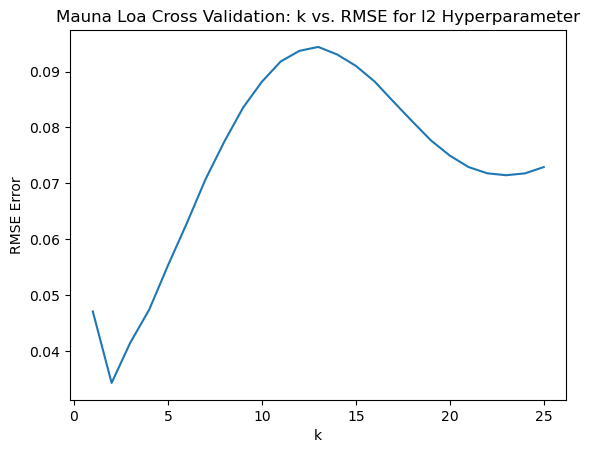

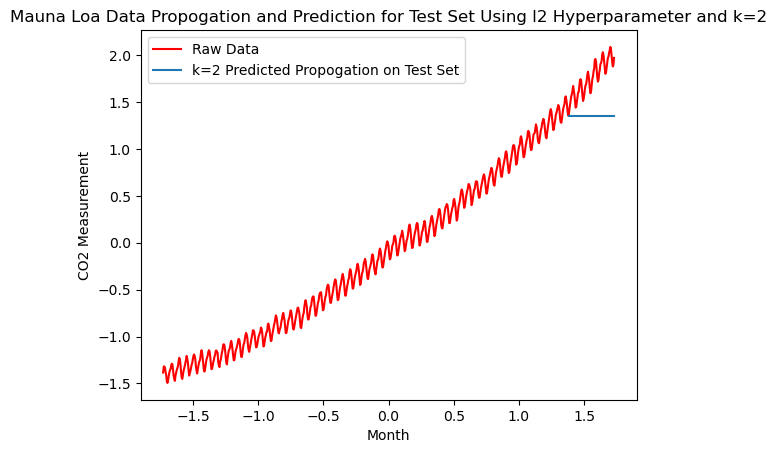

In [6]:
def runQ1(dataset):
    # Plot Mauna Loa results
    if dataset == 'mauna_loa':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
        k, l, rmse, test_rmse = five_fold_crossval(x_train, x_valid, x_test, y_train, y_valid, y_test, dataset)

    # Plot Rosenbrock results
    elif dataset == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=2)
        k, l, rmse, test_rmse = five_fold_crossval(x_train, x_valid, x_test, y_train, y_valid, y_test, dataset)

    # Plot Pumadyn results
    elif dataset == 'pumadyn32nm':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
        k, l, rmse, test_rmse = five_fold_crossval(x_train, x_valid, x_test, y_train, y_valid, y_test, dataset)

    else:
        print('Load Failed')
    
    return k, l, rmse, test_rmse

k, l, rmse, test_rmse = runQ1('mauna_loa')
print(k)
print(l)
print(rmse)
print(test_rmse)

Here are the results of running the regression algorithm on each of the available datasets:

Mauna Loa (t ~ 1s):
- k = 2
- Distance Metric: l1
- Cross Validation RMSE = 0.03580955615716678
- Test RMSE = 0.44070489035463933

Rosenbrock (t ~ 2 min for d=2):
- k = 3
- Distance Metric: l2
- Cross Validation RMSE = 0.2205026426732793
- Test RMSE = 0.23733539021561892

Pumadyn (t ~ 9 min):
- k = 26
- Distance Metric: l1
- Cross Validation RMSE = 0.8703174967220036
- Test RMSE = 0.8317203951757373


**Question 2)**

- Implement k-d tree data structure to determine nearest neighbours (multiple test points simultaneously)
- Use k=5 with l2 distance metric

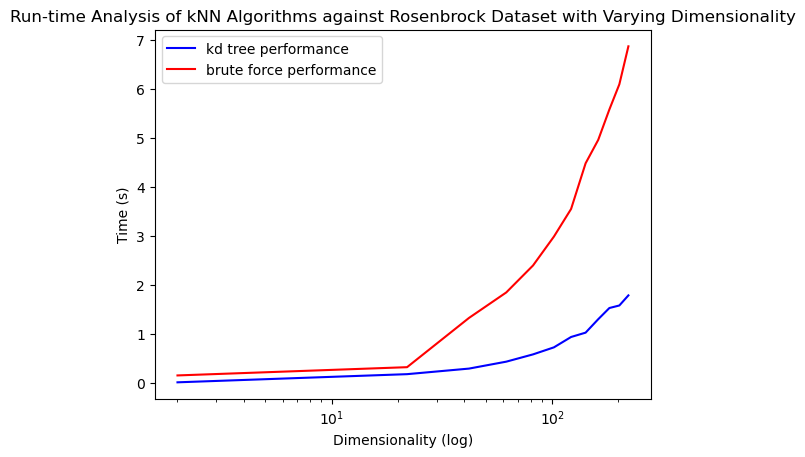

In [5]:
def k_d_tree(x_train, y_train, x_test):
    # Define KD tree and get indices of k nearest neighbours for MULTIPLE POINTS simultaneously 
    tree  = KDTree(x_train)
    k_inds = tree.query(x_test, k=5, return_distance=False)
    # Compute regression -> determine mean of the k nearest neighbours for each point (estimate of y_test value)
    y_est = np.mean(y_train[k_inds], axis=1)

    return y_est

def runQ2():
    # Load Rosenbrock data set with varying values of d
    d_set = np.arange(2,240,20)
    time_set_kd = np.zeros(len(d_set))
    time_set_reg = np.zeros(len(d_set))
    for i, d in enumerate(d_set):
        # Run analysis for all values of d specified and generate arrays of time performance
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=d)

        # Run time analysis for kd tree performance
        t0 = time()
        k_d_tree(x_train, y_train, x_test)
        t1 = time()
        time_set_kd[i] = t1-t0

        # Run time analysis for brute force approach
        t0 = time()
        knn_regression(x_train, y_train, x_test, k=5, l=2)
        t1 = time()
        time_set_reg[i] = t1-t0
    
    # Plot d vs time curve
    plt.semilogx(d_set, time_set_kd, 'b', label='kd tree performance')
    plt.semilogx(d_set, time_set_reg, 'r', label='brute force performance')
    plt.xlabel('Dimensionality (log)')
    plt.ylabel('Time (s)')
    plt.title('Run-time Analysis of kNN Algorithms against Rosenbrock Dataset with Varying Dimensionality')
    plt.legend(loc=0)

runQ2()


From the graph, it is clear that the use of kd trees improves runtimes significantly, especially as we increase the dimensionality.

**Question 3)** 

In [9]:
def common_col_check(col):
    # For each column, we want to determine the most common label
    vote, count = np.unique(col, return_counts=True)
    return vote[np.argmax(count)]

def knn_classifier(x_train, y_train, x_test, k, l):
    # Define KD tree and get indices of k nearest neighbours for MULTIPLE POINTS simultaneously 
    if l == 1:
        tree  = KDTree(x_train, metric='l1')
        k_inds = tree.query(x_test, k=k, return_distance=False)
    elif l == 2:
        tree  = KDTree(x_train, metric='l2')
        k_inds = tree.query(x_test, k=k, return_distance=False)
        
    y_test = np.zeros((len(k_inds), len(y_train[k_inds[0]][0])), dtype=bool)
    # Compute classification -> for each row in k_inds (2D array), we have the k nearest neighbours for a point in x_test 
    for i, kpt_inds in enumerate(k_inds):
        # vote on the most common class for each point
        # If there is a tie, just return the classification of the first occurance. Usually we have a tie condition, but for selecting the optimal k, we will keep k constant for the run
        y_test[i] = np.apply_along_axis(common_col_check, 0, y_train[kpt_inds])

    return y_test

def runQ3(dataset):
    # Determine optimal hyperparameters k and l
    if dataset == 'iris':
        # 3 class classification - True/False for 3 different iris flowers i.e. [True False False] -> one hot encoding
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
    elif dataset == 'mnist':
        # 10 class classification - True/False for the 10 possible digits (0-9) -> one hot encoding
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
    
    k_max = int(np.sqrt(len(x_train)))
    k_accuracy = np.zeros((k_max, 2))
    for k in range(1, k_max+1):
        # Run classifier using all valid k values and see which one maximizes accuracy of classification
        # Run for both distance metrics
        y_est_l1 = knn_classifier(x_train, y_train, x_valid, k, 1)
        y_est_l2 = knn_classifier(x_train, y_train, x_valid, k, 2)
        # Compare classification predictions with true labels to determine accuracy
        k_accuracy[k-1][0] = np.mean(y_est_l1 == y_valid)
        k_accuracy[k-1][1] = np.mean(y_est_l2 == y_valid)

    # Determine optimal hyperparameters from results 
    max_ind = np.unravel_index(np.argmax(k_accuracy, axis=None), k_accuracy.shape)
    k_best = max_ind[0]+1
    maxval_acc = np.max(k_accuracy)
    if max_ind[1] == 0:
        dist_best = 'l1'
        l_best = 1
    else:
        dist_best = 'l2'
        l_best = 2

    # Determine the test accuracy using optimal hyperparameters (how well do parameters do with new data)
    x_train = np.vstack([x_train, x_valid])
    y_train = np.vstack([y_train, y_valid])
    y_test_est = knn_classifier(x_train, y_train, x_test, k_best, l_best)
    test_accuracy = np.mean(y_test_est == y_test)

    return k_best, maxval_acc, dist_best, test_accuracy

runQ3('mnist')

(1, 0.99, 'l2', 0.9918)

Iris Dataset:
- k = 10
- l = l2
- Validation accuracy: 0.9247311827956989
- Test accuracy: 1.0

Mnist Dataset:
- k = 1
- l = l2
- Validation accuracy: 0.99
- Test accuracy: 0.9918

**Question 4)**

In [36]:
def linear_regression(x_train, y_train, x_test):
    # Minimize least squares loss function

    # Introduce dummy feature so that we can write linear regression function as f_hat = Xw
    n_train = len(x_train)
    n_test = len(x_test)
    x_train = np.hstack((np.ones((n_train,1)), x_train))
    x_test = np.hstack((np.ones((n_test,1)), x_test))

    # Compute SVD on x_train to get U, V^T, and singular matrix
    U,S,V = svd(x_train, full_matrices=False)
    # Minimize least squares error by choosing w to be this expression, made up of the SVD components of X
    # w = (V).dot(U.T).dot(y_train)/(S.reshape(-1,1))
    w = V.T.dot(U.T.dot(y_train)/(S.reshape(-1,1)))
    # With fitted weights/coefficients, we can make our test set predicitons
    f_hat = x_test.dot(w)

    return f_hat

def runQ4(dataset):
    if dataset == 'mauna_loa':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
    elif dataset == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)
    elif dataset == 'pumadyn32nm':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
    elif dataset == 'iris':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
    elif dataset == 'mnist':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
    
    # Question specifies to use both training and validation sets to predict on the test set
    x_train = np.vstack((x_valid, x_train))
    y_train = np.vstack((y_valid, y_train))

    f_hat = linear_regression(x_train, y_train, x_test)

    # If a regression dataset, determine test RMSE. If classification dataset, determine test accuracy
    if dataset in ['mauna_loa', 'rosenbrock', 'pumadyn32nm']:
        test_rmse = np.sqrt(np.mean(np.square(f_hat - y_test)))
        return test_rmse
    else:
        # Greater the value, the more likely it is to be True, so compare the max indices between f_hat and y_test for each point
        test_accuracy = np.mean(np.argmax(f_hat, axis=1) == np.argmax(y_test, axis=1))
        return test_accuracy
    
runQ4('mnist')

0.85

**Linear regression results**

Mauna Loa:
- RMSE: 0.34938831049910213

Rosenbrock:
- RMSE: 0.9840872030687701

Pumadyn:
- RMSE: 0.8622512436598077

Iris:
- Test accuracy: 0.8666666666666667

Mnist:
- Test accuracy: 0.85